# [05] Batch GD Training (Concat, norm or sus)
Same code as "[03] Batch GD Training (Side)" but this time we use 2000 and 5000 eigenvectors and are running on our concatenated image dataset. No particularly different results, still shows we need a more complex model.

In [1]:
## Importing libraries
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import os
import math as m
import time

In [ ]:
## loading in important variables

# Eigenvectors
with open('train_concat_vectors.npy', 'rb') as f:
    train_concat_vectors = pickle.load(f) 
vectors = train_concat_vectors

# Keys
with open('OFFICIAL_keys.pkl', 'rb') as f:
    keys = pickle.load(f)
train_set = keys[:int(0.8*len(keys))]
test_set = keys[int(0.8*len(keys)):int(0.9*len(keys))+1]
validation_set = keys[int(0.9*len(keys))+1:]

# Images
with open('concat_imgs.npy', 'rb') as f:
    concat_imgs = pickle.load(f) 
scale = (162, 135)

# Classifications
with open('classifications.pkl', 'rb') as f:
    classifications = pickle.load(f)
classes = []
for i in range(2575):
    if classifications[2*i] != classifications[2*i+1]:
        print("Classification not equal")
    classes.append(classifications[2*i])
classes = np.array(classes)

In [3]:
## Takes flattened images (wxh, n), eigenvectors for the set, and k = new dimensionality
## Returns an array similar to flattened images array but with k instead of n dimensions
def reduce_dimensionality(imgs, vecs, k):
    reduced_dim = np.matmul(vecs[:k], imgs)
    return reduced_dim

## Converts the reduced dimension scan back to original image dimension
def reduced_to_img(reduced, vecs):
    approx = np.matmul(vecs[:reduced.shape[0]].T, reduced)
    return approx

## Combined the above two functions for convenience in creating downscaled images
def reduce_img_dim(imgs, vecs, k):
    return reduced_to_img(reduce_dimensionality(imgs, vecs, k), vecs)

In [11]:
## Set inputs and labels reducing image dimensionality down to 2000 and 5000 (for later test)
dims = 2000
inputs = reduce_dimensionality(concat_imgs.T, vectors, dims).T
dims = 5000
inputs5000 = reduce_dimensionality(concat_imgs.T, vectors, dims).T

labels = []
for i in range(classes.shape[0]):
    if classes[i] == "D2 Normal":
        labels.append(0)
    else:
        labels.append(1)

labels = np.array(labels)

In [5]:
## Function to calculate class weights (never was able to implement weights but is useful for seeing class disparity)
def calculate_weights(labels):
    zero = np.count_nonzero(labels==0)
    ones = np.count_nonzero(labels==1)
    zero_freq = zero/labels.shape[0]
    ones_freq = ones/labels.shape[0]
    print(zero_freq, ones_freq)
    zero_weight = 0.5/zero_freq
    ones_weight = 0.5/ones_freq
    print(zero_weight, ones_weight)
    weights = []
    for i in range(labels.shape[0]):
        if labels[i] == 1:
            weights.append(ones_weight)
        else:
            weights.append(zero_weight)
    weights = np.array(weights)
    return weights
weights = calculate_weights(labels)
print(weights.shape)

0.2803883495145631 0.7196116504854368
1.783240997229917 0.6948192120885052
(2575,)


In [9]:
## Creating an even training set that doesn't have class imbalance by removing some of our positives
train_set_5050 = []
count = 0
for i in range(train_set.shape[0]):
    if classes[train_set[i]] == "D2 Normal":
        train_set_5050.append(train_set[i])
    else:
        if count<575:
            train_set_5050.append(train_set[i])
            count+=1
train_set_5050 = np.array(train_set_5050)
print(train_set_5050.shape)
pos, neg = 0, 0
for c in train_set_5050:
    if labels[c] == 1:
        pos+=1
    else:
        neg+=1
print(pos, neg)
print(train_set_5050)

(1150,)
575 575
[1923 1251 1170 ... 2028 2038 2231]


In [10]:
## SGD function to train a classifier taken from Max's MP3
#Find best a, b s.t. min Loss = ||a.Tx+b-y||^2

def train_classifier(train_filenames, test_filenames, labels, inputs, epochs=10, batch_size=4, lr=0.01, momentum=0.5, return_accuracy=False, shuffling=True):
    
    def mse(a, b):
        return np.square(np.subtract(a, b)).mean()
    
    def a_dir(a, b, x, y):
        derivative = 2 * (np.matmul(a.T, x) + b - y)*x
        return derivative
    
    def b_dir(a, b, x, y):
        derivative = 2 * (np.matmul(a.T, x) + b - y)
        return derivative
    
    def get_batch(keys, labels, inputs, batch_num):
        batch_keys = keys[batch_num*batch_size:(batch_num+1)*batch_size]
        return labels[batch_keys], inputs[batch_keys]
    
    def SGD(train_filenames, test_filenames, labels, inputs, epochs, batch_size, lr):
        
        inputs_shape = inputs.shape[1]
        a = np.zeros((inputs_shape))
        b = 0.0
        
        num_iters = m.ceil(len(train_filenames)/batch_size)
        train_loss = []
        test_loss = []
        accuracy = []
        a_max, b_max, epoch_max, accuracy_max = 0, 0, 0, 0
        for e in range(epochs):
            batch_num = 0
            if shuffling:
                np.random.shuffle(train_filenames)
            for iters in range(num_iters):
                batch_labels, batch_inputs = get_batch(train_filenames, labels, inputs, batch_num)
                batch_num = batch_num + 1
                
                sum_a_dir, sum_b_dir = 0, 0
                for i in range(batch_labels.shape[0]):
                    sum_a_dir = sum_a_dir + a_dir(a, b, batch_inputs[i], batch_labels[i])
                    sum_b_dir = sum_b_dir + b_dir(a, b, batch_inputs[i], batch_labels[i])
                a_new = a-(lr/batch_labels.shape[0])*sum_a_dir
                b_new = b-(lr/batch_labels.shape[0])*sum_b_dir
                a, b = a_new, b_new
            if not return_accuracy:
                train_est_vec = np.zeros(len(train_filenames))
                train_given_vec = np.zeros(len(train_filenames))
                test_est_vec = np.zeros(len(test_filenames))
                test_given_vec = np.zeros(len(test_filenames))
                for i in range(len(train_filenames)):
                    idx = train_filenames[i]
                    train_est_vec[i] = (np.matmul(a.T, inputs[idx]) + b)
                    train_given_vec[i] = (labels[idx])
                for i in range(len(test_filenames)):
                    idx = test_filenames[i]
                    test_est_vec[i] = (np.matmul(a.T, inputs[idx]) + b)
                    test_given_vec[i] = (labels[idx])
                train_loss.append(mse(train_est_vec, train_given_vec))
                test_loss.append(mse(test_est_vec, test_given_vec))
            if return_accuracy:
                this_accuracy = test_classifier(a, b, test_set, labels, inputs)
                accuracy.append(this_accuracy)
                if this_accuracy > accuracy_max:
                    a_max = a
                    b_max = b
                    epoch_max = e
                    accuracy_max = this_accuracy
        if return_accuracy:
            return a_max, b_max, epoch_max, accuracy
        else:
            return a, b, train_loss, test_loss
    
    #feel free to add any other methods here
    
    return SGD(train_filenames, test_filenames, labels, inputs, epochs, batch_size, lr)

In [11]:
## Helper function to simplify plotting code
def plot_loss(data, label="", title="Loss", xlabel="Update Iteration", ylabel="Loss", log_scale=True, legend=False, single=False):
    plt.figure(1)
    plt.title(title)
    if single:
        plt.plot(data, label=label)
    else:
        for i in range(len(data)):
            plt.plot(data[i], label=label[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if log_scale: plt.yscale('log')
    if legend: plt.legend(loc='best')
    plt.show()

In [12]:
## This function will run the training algorithm with different learning rates (lr) and plot the results of the loss curves
def plot_lr_loss_diff(lr, log_scale=True, epochs=1000, batch_size=5):
    train_loss_list = []
    test_loss_list = []
    lr_labels = []
    for i in range(len(lr)):
        print(f"{i+1}/{len(lr)}:", end=' ')
        start = time.time()
        a, b, this_train_loss, this_test_loss = train_classifier(train_set, test_set, labels, inputs, epochs, batch_size, lr[i])
        train_loss_list.append(this_train_loss)
        test_loss_list.append(this_test_loss)
        lr_labels.append(lr[i])
        print(f"Learning Rate {lr[i]} took", time.time()-start, "seconds")
    plot_loss(train_loss_list, label=lr_labels, title=f"Training Loss (batch_size={batch_size}, epochs={epochs})", legend=True)
    plot_loss(test_loss_list, label=lr_labels, title=f"Testing Loss (batch_size={batch_size}, epochs={epochs})", legend=True) 

In [30]:
## Tests the accuracy of the classifier
def test_classifier(a, b, filenames, labels, inputs, to_print=False):
    correct = 0
    if to_print:
        positive_correct = 0
        positive_wrong = 0
        negative_correct = 0
        negative_wrong = 0
    for i in filenames:
        y = labels[i]
        p, n, c = False, False, False
        yhat = np.matmul(a.T, inputs[i]) + b
        if yhat > 0.5:
            yhat = 1
            if to_print: p = True
        else:
            yhat = 0
            if to_print: n = True
        if yhat == y:
            correct = correct + 1
            if to_print: c = True
        if to_print:
            if c:
                if p: positive_correct+=1
                else: negative_correct+=1
            else:
                if p: positive_wrong+=1
                else: negative_wrong+=1
    if to_print: print(f"Positives (Correct/Wrong)={positive_correct}/{positive_wrong}, Negatives (Correct/Wrong)={negative_correct}/{negative_wrong}")
    return correct/len(filenames)

In [14]:
## Same as plot_lr_loss_diff but for batch_sizes
def plot_batch_size_loss_diff(batch_size, log_scale=True, lr=1e-4, epochs=1000):
    train_loss_list = []
    test_loss_list = []
    batch_labels = []
    for i in range(len(batch_size)):
        print(f"{i+1}/{len(batch_size)}:", end=' ')
        start = time.time()
        try:
            a, b, this_train_loss, this_test_loss = train_classifier(train_set, test_set, labels, inputs, epochs, batch_size[i], lr)
        except:
            print(f"Batch size of {batch_size[i]} explodes")
            continue
        train_loss_list.append(this_train_loss)
        test_loss_list.append(this_test_loss)
        batch_labels.append(batch_size[i])
        print(f"Batch size {batch_size[i]} took", time.time()-start, "seconds")
    plot_loss(train_loss_list, label=batch_labels, title=f"Training Loss (LR={lr}, epochs={epochs})", legend=True)
    plot_loss(test_loss_list, label=batch_labels, title=f"Testing Loss (LR={lr}, epochs={epochs})", legend=True) 

1/3: Learning Rate 0.001 took 17.92740488052368 seconds
2/3: Learning Rate 0.0001 took 17.625590085983276 seconds
3/3: Learning Rate 1e-05 took 17.57448983192444 seconds


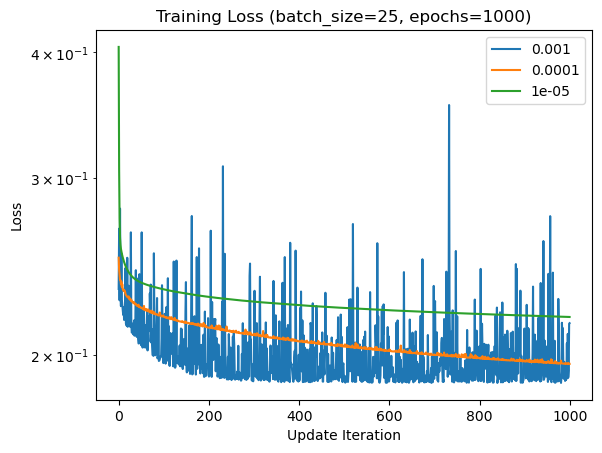

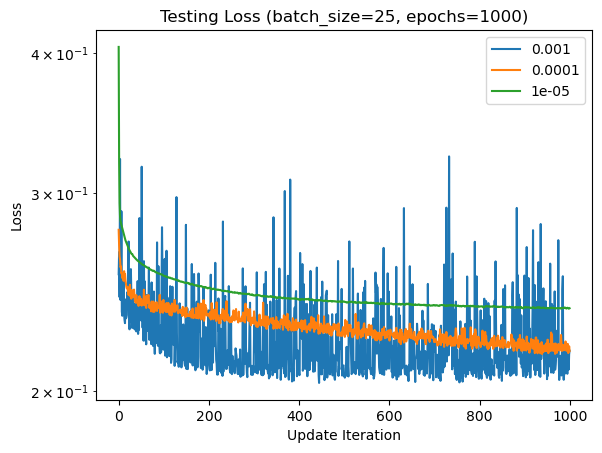

In [8]:
## Plot loss at different learning rates
lr = [1e-3, 1e-4, 1e-5]
plot_lr_loss_diff(lr, batch_size=25, epochs=1000, log_scale=False)

1/3: Batch size 10 took 18.700443029403687 seconds
2/3: Batch size 25 took 18.000861167907715 seconds
3/3: Batch size 50 took 17.35291814804077 seconds


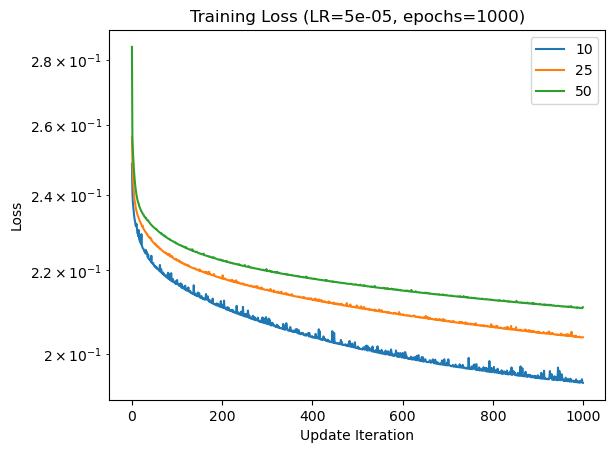

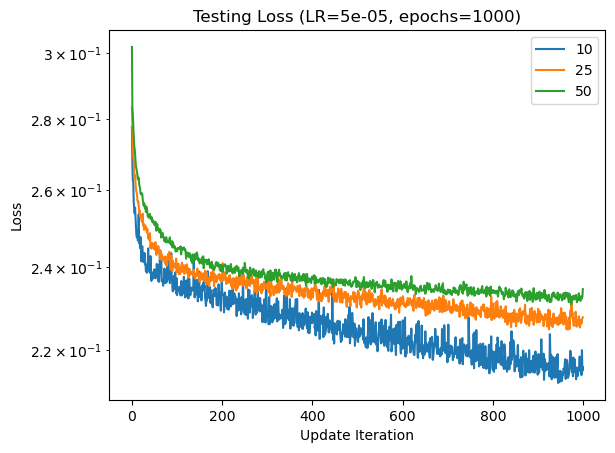

In [11]:
## Plot loss at different batch sizes
batch_sizes = [10, 25, 50]
plot_batch_size_loss_diff(batch_sizes, lr=5e-5, epochs=1000)

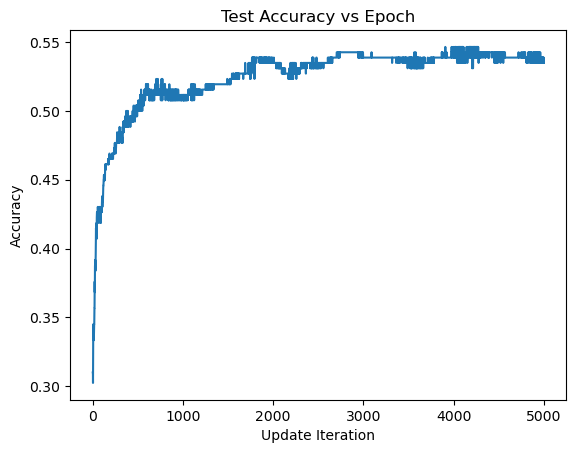

Wall time: 22min 40s


In [36]:
%%time
## Run Accuracy vs. Epoch Results (with shuffling of batches) and then take the maximum accuracy a and b values
## Training on the 0/1 split 50/50 dataset to try to make the model choose evenly
## Training using 2000 eigenvectors
epochs = 5000
batch_size = 25
lr = 1e-5
a_max, b_max, epoch_max, accuracy = train_classifier(train_set_5050, test_set, labels, inputs, epochs, batch_size, lr, return_accuracy=True)
plot_loss(accuracy,title="Test Accuracy vs Epoch", xlabel="Update Iteration", ylabel="Accuracy", log_scale=False, legend=False, single=True)

In [37]:
## Test accuracy on train_set
test_classifier(a_max, b_max, train_set, labels, inputs, True)

Positives (Correct/Wrong)=912/99, Negatives (Correct/Wrong)=476/573


0.6737864077669903

In [38]:
## Test accuracy on test_set
test_classifier(a_max, b_max, test_set, labels, inputs, True)

Positives (Correct/Wrong)=97/36, Negatives (Correct/Wrong)=44/81


0.5465116279069767

In [39]:
## Test accuracy on validation_set
test_classifier(a_max, b_max, validation_set, labels, inputs, True)

Positives (Correct/Wrong)=86/24, Negatives (Correct/Wrong)=43/104


0.5019455252918288

In [40]:
test_classifier(a_max, b_max, keys, labels, inputs)

0.643883495145631

In [41]:
print(epoch_max)

3908


In [25]:
## Checking the category splits of each set
count = 0
for l in labels[train_set]:
    if l == 1:
        count+=1
print(count/labels[train_set].shape[0])

count = 0
for l in labels[test_set]:
    if l == 1:
        count+=1
print(count/labels[test_set].shape[0])

count = 0
for l in labels[validation_set]:
    if l == 1:
        count+=1
print(count/labels[validation_set].shape[0])

0.720873786407767
0.689922480620155
0.7392996108949417


In [ ]:
%%time
## Run Accuracy vs. Epoch Results (with shuffling of batches) and then take the maximum accuracy a and b values
## Training on the 0/1 split 50/50 dataset to try to make the model choose evenly
## Training using 5000 eigenvectors
epochs = 5000
batch_size = 25
lr = 1e-5
a_max, b_max, epoch_max, accuracy = train_classifier(train_set_5050, test_set, labels, inputs5000, epochs, batch_size, lr, return_accuracy=True)
plot_loss(accuracy,title="Test Accuracy vs Epoch", xlabel="Update Iteration", ylabel="Accuracy", log_scale=False, legend=False, single=True)

In [ ]:
## Test accuracy on train_set
test_classifier(a_max, b_max, train_set, labels, inputs5000, True)

In [ ]:
## Test accuracy on test_set
test_classifier(a_max, b_max, test_set, labels, inputs5000, True)

In [ ]:
## Test accuracy on validation_set
test_classifier(a_max, b_max, validation_set, labels, inputs5000, True)